# Exploring School Data and SAT Results

With COVID-19, many US universities decided to no longer require applicants to provide their SAT scores. Even as the pandemic begin to fade, some universities will continue to make SAT scores optional for applicants. This is due to longstanding concerns that the SAT unfairly favors certain kinds of high school students.

This project will examine whether SAT scores and data from New York Public School show any bais towards or against certain students and schools. We will use several datasets that the New York Public School system has made avaliable online.

In [1]:
import pandas as pd
import numpy
from numpy import arange
import re
from cycler import cycler
import matplotlib.pyplot as plt
from matplotlib import cm

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

In [2]:
#setting up tableau 10 color palette to use

tab_blue = '#4E79A7'
tab_orange = '#F28E2B'
tab_red = '#E15759'
tab_sea = '#76B7B2'
tab_green = '#59A14F'
tab_yellow = '#EDC984'
tab_purple = '#B07AA1'
tab_pink = '#FF9DA7'
tab_punce = '#bcbd22'

## Data Cleaning and Prep

We will use survey data, high school directory data, AP class data, class size data, demographic data, and SAT scores for our anaysis. We'll read in the various dataset, convert data to numeric categories where necessary, and combine the information into one dataframe.

In [3]:
#Reading in survey data
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

/var/folders/95/nj257d754011vnq1qhd9l_ym0000gn/T/ipykernel_3772/2952009573.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  survey["DBN"] = survey["dbn"]


In [4]:
#reading in school directory with class-size and school district ref numbers
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

In [5]:
#covert text columns to numeric
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

In [6]:
#condense datasets

class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

In [7]:
#convert AP scores from text to numeric
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

In [8]:
#combine datasets
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

/var/folders/95/nj257d754011vnq1qhd9l_ym0000gn/T/ipykernel_3772/3412793749.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  combined = combined.fillna(combined.mean())


In [9]:
#add school district column for mapping
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Prelimary Exploration

Now that we have our data cleaned and organized, we'll do some quick, prelimary analysis to get a sense of potential areas for further investigation.

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
correlations = combined.corr()
correlations = correlations["sat_score"]

In [12]:
#Highest negative correlations
correlations.sort_values().head(5)

frl_percent    -0.722225
sped_percent   -0.448170
ell_percent    -0.398750
hispanic_per   -0.396985
black_per      -0.284139
Name: sat_score, dtype: float64

In [13]:
#Determining correlation between survey fields and SAT scores
cor = combined.corr()
survey_cor = cor['sat_score'][survey_fields]

survey_cor_df = pd.DataFrame(survey_cor)
survey_cor_list = survey_cor_df['sat_score'].tolist()

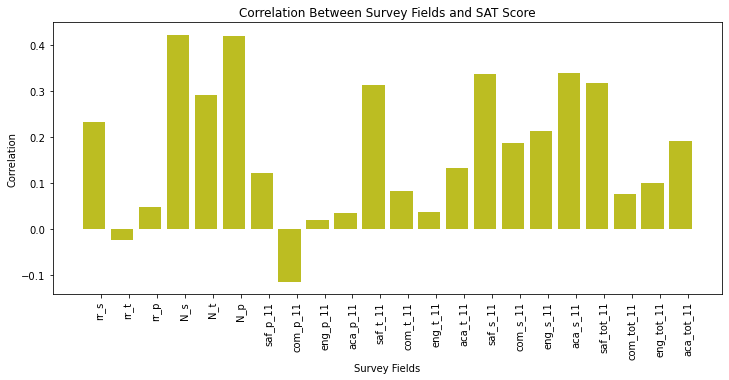

In [14]:
#Plotting correlation between survey fields and SAT scores
%matplotlib inline
x= arange(22)+0.75
height= survey_cor_list

fig, ax_1 = plt.subplots(figsize=(12,5))

ax_1.bar(x, height, width=0.8, color='#bcbd22')
ax_1.set_title('Correlation Between Survey Fields and SAT Score')
ax_1.set_xlabel('Survey Fields')
ax_1.set_ylabel('Correlation')
ax_1.set_xticks(range(1,23))
ax_1.set_xticklabels(survey_fields, rotation=90)
plt.style.use('bmh')

Number of student responses (N_s), Number of teacher responses (N_t) and Number of parent responses(N_p) have strong correlation. This makes sense because these fields also correlate with total enrollement which we already established is correlated with SAT scores. 

Teachers' and students' safety and respect responses (Saf_t_11 and Saf_s_11) also correlated with SAT Scores. Total responses for safety and respect (saf_tot_11) also showed correlation. It seems logical that safety and respect would correlate with SAT Scores.

Surprisingly, students view of a school's academic expectation (aca_s_11) showed a high correlation while parents' and teachers' view of a schools' academic expectation (aca_p_11 and aca_t_11) showed a low correlation.

## Investigating Safety Scores

Given that both students' and teachers' view of school's safety had strong correlation with SAT scores, we will do further analysis to see if there is a relationship between safety and SAT scores.

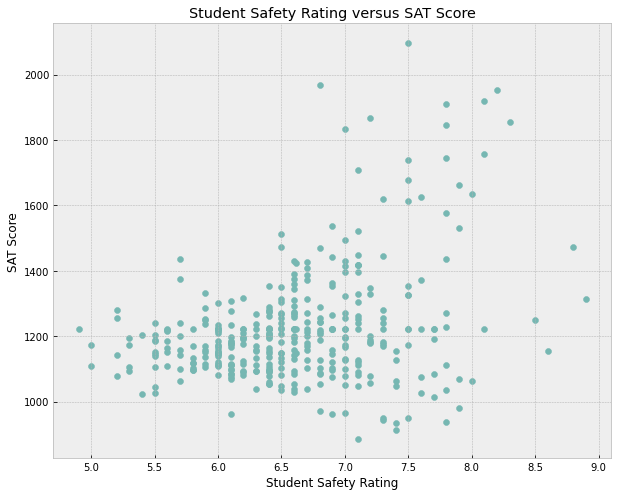

In [15]:
#plotting student safety scores versus sat_scores

x=combined['saf_s_11']
y=combined['sat_score']

fig, ax_1 = plt.subplots(figsize=(10, 8))

ax_1.scatter(x,y, color= tab_sea)
ax_1.set_title('Student Safety Rating versus SAT Score')
ax_1.set_ylabel('SAT Score')
ax_1.set_xlabel('Student Safety Rating')
plt.style.use('bmh')

plt.show()

Looking at the scatter plot above, there does seem to be a weak relationship between students' perception of safety and SAT score. The relationship looks strongest between schools with high student safety and high SAT scores. However, schools with lower student safety and low-to-moderate SAT scores do not show a clear relationship.

Next, we will map the school and safety scores for each District in New York City to see if it provides further insight into the potential relationship.

In [16]:
#computing the average safety score for each district
school_dist_saf = combined.groupby('school_dist').agg(numpy.mean).reset_index()
school_dist_saf['saf_s_11']

0     6.768611
1     6.910660
2     6.716667
3     6.885714
4     6.314286
5     6.950000
6     6.800000
7     6.364697
8     6.655000
9     6.577273
10    6.186667
11    7.116667
12    6.407692
13    6.685714
14    6.177778
15    5.875000
16    6.007143
17    6.190909
18    6.150000
19    7.120000
20    6.390909
21    7.025000
22    6.233333
23    7.107692
24    6.912500
25    6.760000
26    6.390000
27    6.627273
28    6.075000
29    7.033333
30    6.530000
31    6.766667
Name: saf_s_11, dtype: float64

<AxesSubplot:xlabel='boro'>

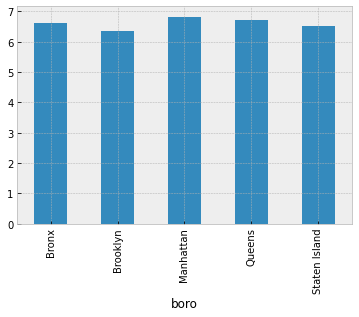

In [19]:
#Getting Safety Scores by New York City borough
boros = combined.groupby("boro").agg(numpy.mean)["saf_s_11"]
boros.plot.bar()

Looking at the graph of boroughs above, it looks like Brooklyn has the lowest safety scores.

In [43]:
bottomq = combined['saf_s_11'].describe()[4]
least_safe = combined[combined['saf_s_11'] <= bottomq]

least_safe['boro'].value_counts(normalize=True)

Brooklyn         0.43
Bronx            0.26
Manhattan        0.14
Queens           0.13
Staten Island    0.04
Name: boro, dtype: float64

Looking more closely at the bottom quartile schools for safety, we can see that the largest precentage of least safe school are located in Brooklyn.

# Race and SAT Scores

Next we will examine demographic data to determine if there are any relationships between race and SAT scores, which might indicate that some racial groups have advantages or disadvantages in taking the test. 

### Correlation Between Race and Scores

In [44]:
#Determining correlation between white, asian, black, and hispanic 
#students and their SAT Score
race_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

corr_race = combined.corr()
corr_race = corr_race['sat_score'][race_cols]
corr_race

white_per       0.620718
asian_per       0.570730
black_per      -0.284139
hispanic_per   -0.396985
Name: sat_score, dtype: float64

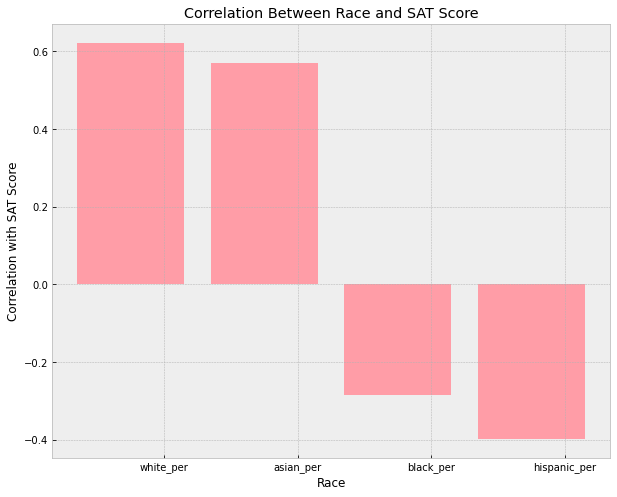

In [45]:
#plotting correlation between race and SAT Scores
x= arange(4) + 0.75
height = corr_race

fig, ax_1 = plt.subplots(figsize=(10,8))

ax_1.bar(x, height, width=0.8, color=tab_pink)
ax_1.set_xticks(range(1,5))
ax_1.set_xticklabels(race_cols)
ax_1.set_title('Correlation Between Race and SAT Score')
ax_1.set_xlabel('Race')
ax_1.set_ylabel('Correlation with SAT Score')
plt.style.use('fivethirtyeight')

From the chart above, we can see that white and asian students have a positive correlation with SAT scores while black and hispanic students havea negative correlation with SAT scores. 

### Examining Schools' SAT Scores and Hispanic Enrollment 

Next, we'll closely examining schools with low SAT scores and high numbers of hispanic students to see what other factors might influence the negative correlation. 

Text(0.5, 1.0, 'Hispanic Enrollment versus SAT Scores')

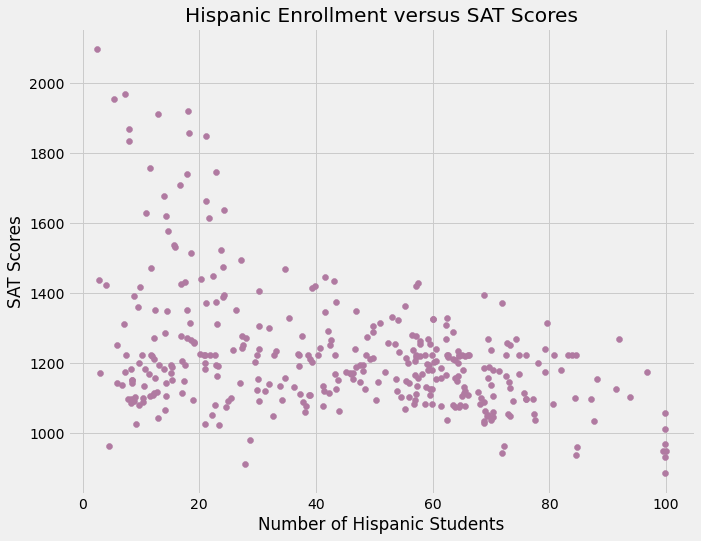

In [46]:
#plotting hispanic enrollement versus sat_scores
x=combined['hispanic_per']
y=combined['sat_score']

fig, ax_1 = plt.subplots(figsize=(10,8))

ax_1.scatter(x,y,c=tab_purple)
ax_1.set_xlabel('Number of Hispanic Students')
ax_1.set_ylabel('SAT Scores')
ax_1.set_title('Hispanic Enrollment versus SAT Scores')

### Schools With High Hispanic Enrollment

In [47]:
#Identifying schools with high hispanic enrollment 
high_his = combined[combined['hispanic_per'] > 95]
high_his['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

A quick Google search shows that some of these schools focus on serving student for whom English is thier second language. The SAT is only offered in English and that might disadvantage some students from these schools. 

### Schools With Low Hispanic Enrollment

In [48]:
#Identifying schools with low hispanic enrollment
low_his_high_sat= combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]
low_his_high_sat['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools with the highest SAT scores and lowest hispanic enrollment rates are charter schools that focus on STEM subjects and require extremely competitive entrance exams. This background probably helps explain their students' high SAT scores (the student population at these schools have already demonstrated strength in standardized testing) but it does not explain the low hispanic enrollement. 

# Scores and Gender

First, we will check to see if there is any correlation between gender and SAT scores.

In [49]:
#Calculating correlations between gender and sat_score

gender_corr = combined.corr()
gender_corr = gender_corr.loc[['female_per','male_per'], 'sat_score']
gender_corr

female_per    0.112108
male_per     -0.112062
Name: sat_score, dtype: float64

[Text(1, 0, 'female_per'), Text(2, 0, 'male_per')]

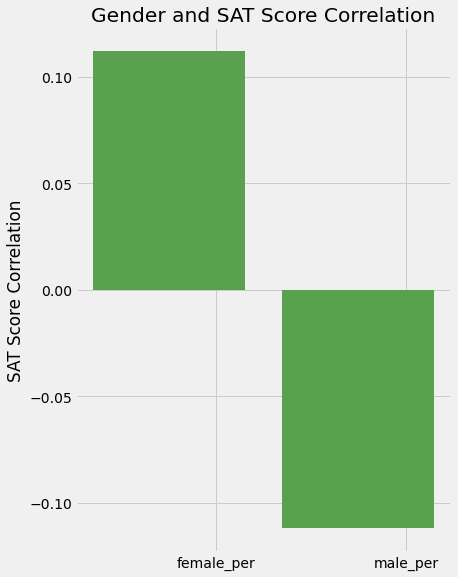

In [50]:
#Plotting correlation on bar chart
x = arange(2)+0.75
height = gender_corr

fig, ax1 = plt.subplots(figsize=(6,9))

ax1.bar(x,height, width=0.8, color=tab_green)
ax1.set_title('Gender and SAT Score Correlation')
ax1.set_ylabel('SAT Score Correlation')
ax1.set_xticks((1,2))
ax1.set_xticklabels(combined[['female_per','male_per']])


Women have a slight postive correlation with SAT scores while men have a slight negative correlation with SAT scores.

### High SAT Scores Versus Females Enrollment

Text(0, 0.5, 'SAT Score')

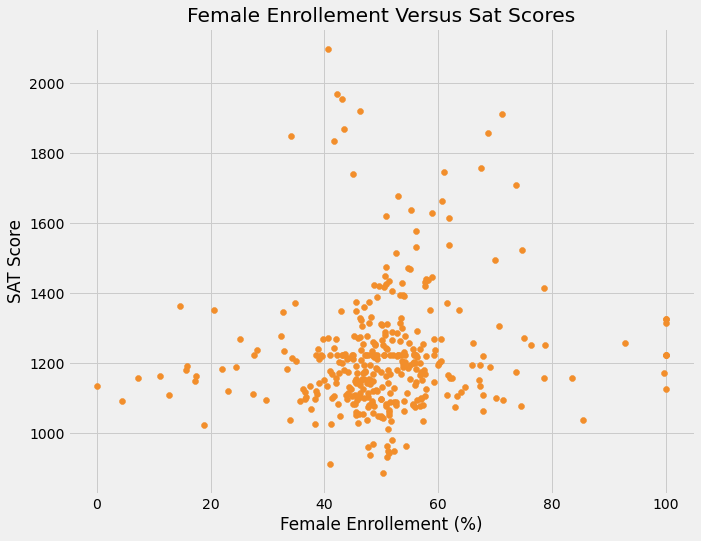

In [51]:
#Creating scatter plot to examine schools with large numbers of women 
# and high SAT scores

fig, ax1 = plt.subplots(figsize=(10,8))

ax1.scatter(x=combined['female_per'], y=combined['sat_score'], 
            color=tab_orange)
ax1.set_title('Female Enrollement Versus Sat Scores')
ax1.set_xlabel('Female Enrollement (%)')
ax1.set_ylabel('SAT Score')

Based on the scatter plot above, there does not appear to be strong relationship between female enrollment and SAT scores. 

### Schools With High Female Enrollment and SAT Scores

In [52]:
#identifying schools with high female enrollment and high SAT Scores
high_f_sat = combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]
high_f_sat['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Another quick Google search of these schools reveals that all the schools with high female enrollment and high SAT scores are prestigous liberal arts high schools.

# AP Exams and SAT Scores

Next we'll examine the relationship between SAT Scores and AP exams. To avoid total enrollment numbers biasing our results we will look at the percentage of students in each school that took at least one AP exam.

In [53]:
#Calculating the percent of students who took an AP Exam 
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

Text(0, 0.5, 'SAT Scores')

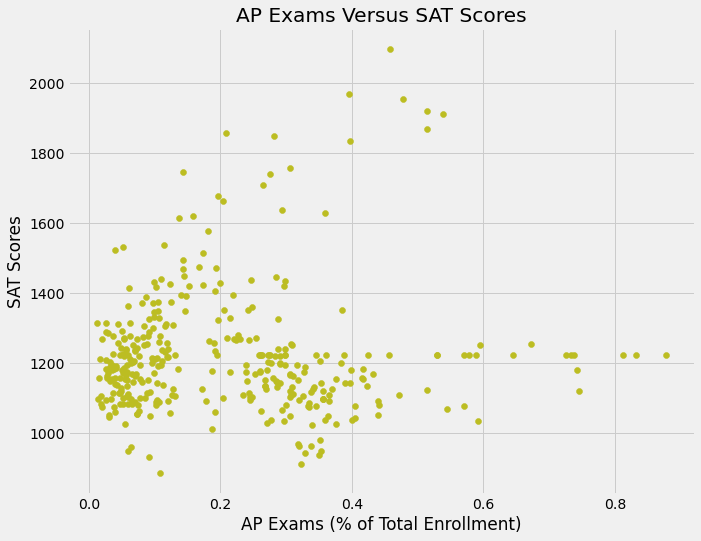

In [54]:
#Creating scatter plot to analyze relationship betweeen AP Exam and Sat Score
fig, ax1 = plt.subplots(figsize=(10,8))

ax1.scatter(x=combined['ap_per'], y=combined['sat_score'], 
            color=tab_punce)
ax1.set_title('AP Exams Versus SAT Scores')
ax1.set_xlabel('AP Exams (% of Total Enrollment)')
ax1.set_ylabel('SAT Scores')

Based on the scatter plot above, there does appear to be a very weak relationship between the number of students taking at least one AP exam and SAT scores.